# PyDDA tutorial

![PyDDA logo](https://openradarscience.org/PyDDA/_images/logo.png)


PyDDA is an open source Python package for retrieving winds using Multiple Doppler analyses. It uses the 3D variational technique for retrieving winds from multiple Doppler radars. It uses Py-ART Grid Objects as inputs. Therefore, preprocessed and gridded data are needed for PyDDA to run.

## 3D variational technique
PyDDA uses a 3D variational technique to retrieve the 3D wind field. We will leave students that are interested in more information about these technqiues two references to read at the end of this notebook. A basic introduction to 3D variational analysis is given here.

PyDDA minimizes a cost function $J$ that corresponds to various penalties including:

$J_{m} = \nabla \cdot V$ which corresponds to the mass continuity equation.

$J_{o} = $ RMSE between radar winds and analysis winds.

$J_{b} = $ RMSE between sounding winds and analysis winds.

$J_{s} = \nabla^2 V$ which corresponds to the smoothness of wind field to eliminate high-frequency noise that can result from numerical instability.

The cost function to be minimized is a weighted sum of the various cost functions in PyDDA and are represented in Equation (1):

<p style="text-align: center;">$J = c_{m}J_{m} + c_{o}J_{o} + c_{b}J_{b} + c_{s}J_{s} + ...$ (1)</p>

### References


## Imports

Let's import the necessary libraries. For now, we'll need PyART, glob, matplotlib, and PyDDA.

In [158]:
import glob
import fsspec

import pyart
import matplotlib.pyplot as plt
import pydda
import warnings
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
warnings.filterwarnings("ignore")

## Case study

We will examine the same case study over Northern Alabama that has been used for this entire short course. For this case in April 2008, we had an MCS with supercells out ahead of the main line approach the Huntsville, AL region. 3D variational retrievals of thunderstorm updrafts can have uncertainties on the order of 5 m/s. In addition these retrievals require precipitation coverage throughout the domain. Therefore, 3DVAR retrievals are best suited for deep convection like this where the updrafts are strong and precipitation coverage is wide.

For this case, we had coverage of the storm from two radars, the ARMOR and the Huntsville NEXRAD radar 

### UAH ARMOR Radar

We need to load and preprocess the UAH armor data first. In order to do so, we first need to load the ARMOR radar file.

In [3]:
files = glob.glob('../../data/uah-armor/*')
radar = pyart.io.read(files[1])

### Dealiasing

The next step is to dealias the radar data. We will follow the steps that were shown eariler in this course to dealias the radar data.

In [4]:
nyquist = radar.instrument_parameters['nyquist_velocity']['data'][0]
vel_dealias = pyart.correct.dealias_region_based(radar,
                                                    vel_field='velocity',
                                                    nyquist_vel=nyquist,
                                                    centered=True,
                                                    )
radar.add_field('corrected_velocity', vel_dealias, replace_existing=True)

Plot the data to make sure dealiasing succeeded.

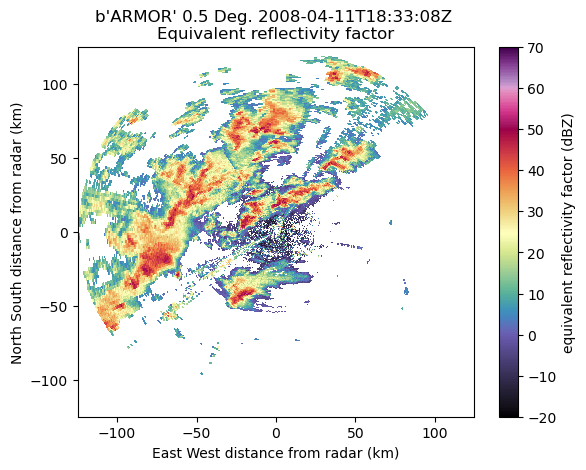

In [5]:
display = pyart.graph.RadarDisplay(radar)
display.plot('reflectivity',
             vmin=-20,
             vmax=70,
             cmap='pyart_ChaseSpectral',
             sweep=0)

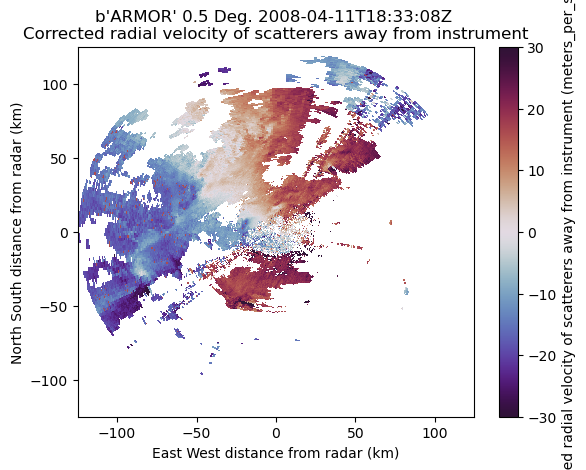

In [6]:
display = pyart.graph.RadarDisplay(radar)
display.plot('corrected_velocity',
             vmin=-30,
             vmax=30,
             cmap='twilight_shifted',
             sweep=0)

## Gridding

PyDDA requires data to be gridded to Cartesian coordinates in order to retrieve the 3D wind fields. Therefore, we will use Py-ART's *grid_from_radars* function in order to do the gridding. You usually want to have a grid resolution such that your features of interest are covered by four grid points. In this case, we're at 1 km horizontal and 0.5 km vertical resolution. (Ask if we are covering gridding in Py-ART and wait for link here)

In [27]:
grid_limits = ((0., 15000.), (-50_000., 50_000.), (-50_000., 50_000.))
grid_shape = (31, 101, 101)
uah_grid = pyart.map.grid_from_radars([radar], grid_limits=grid_limits,
                                 grid_shape=grid_shape)
uah_ds = uah_grid.to_xarray()
uah_ds

<xarray.Dataset>
Dimensions:                      (time: 1, z: 31, y: 101, x: 101)
Coordinates:
  * time                         (time) object 2008-04-11 18:33:08
  * z                            (z) float64 0.0 500.0 ... 1.45e+04 1.5e+04
    lat                          (y, x) float64 34.2 34.2 34.2 ... 35.09 35.09
    lon                          (y, x) float64 -87.32 -87.3 ... -86.23 -86.22
  * y                            (y) float64 -5e+04 -4.9e+04 ... 4.9e+04 5e+04
  * x                            (x) float64 -5e+04 -4.9e+04 ... 4.9e+04 5e+04
Data variables:
    corrected_velocity           (time, z, y, x) float32 nan nan nan ... nan nan
    differential_phase           (time, z, y, x) float32 nan nan nan ... nan nan
    total_power                  (time, z, y, x) float32 nan nan nan ... nan nan
    spectrum_width               (time, z, y, x) float32 nan nan nan ... nan nan
    cross_correlation_ratio      (time, z, y, x) float32 nan nan nan ... nan nan
    velocity                     (time, z, y, x) float32 nan nan nan ... nan nan
    reflectivity                 (time, z, y, x) float32 nan nan nan ... nan nan
    differential_reflectivity    (time, z, y, x) float32 nan nan nan ... nan nan
    specific_differential_phase  (time, z, y, x) float32 nan nan nan ... nan nan
    ROI                          (time, z, y, x) float32 1.852e+03 ... 2.602e+03

Let's make sure the grid looks good!

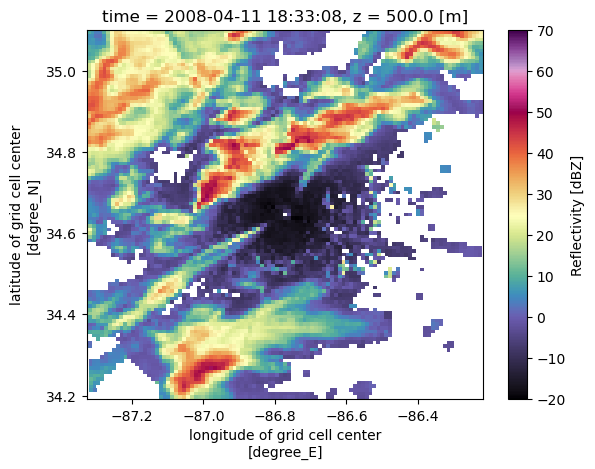

In [28]:
uah_ds.isel(z=1).reflectivity.plot(x='lon',
                                   y='lat',
                                   vmin=-20,
                                   vmax=70,
                                   cmap='pyart_ChaseSpectral')

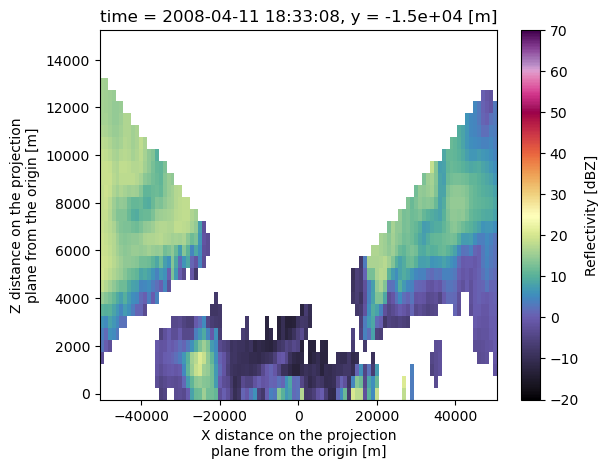

In [32]:
uah_ds.isel(y=35).reflectivity.plot(x='x',
                                   y='z',
                                   vmin=-20,
                                   vmax=70,
                                   cmap='pyart_ChaseSpectral')

### NEXRAD Data

Next, we need to load the NEXRAD data. This is available on Amazon Web Services under the noaa-nexrad-level2 bucket. This S3 bucket has all of the historical NEXRAD WSR-88D level 2 data that is available for the continential US Use the below code snippet to retrieve the NEXRAD data from Amazon Web Services.

In [11]:
fs = fsspec.filesystem("s3", anon=True)
files = sorted(fs.glob("s3://noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_18*"))
files

['noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_180040.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_180647.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_181144.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_181643.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_182140.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_182639.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_183137.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_183635.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_184134.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_184632.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_185130.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_185628.gz']

Read a single file, the one closes to the UAH volume scan used before

In [13]:
nexrad_radar = pyart.io.read_nexrad_archive(f's3://{files[7]}', station='KHTX')

Visualize the data to make sure we have the correct scan.

(-200.0, 200.0)

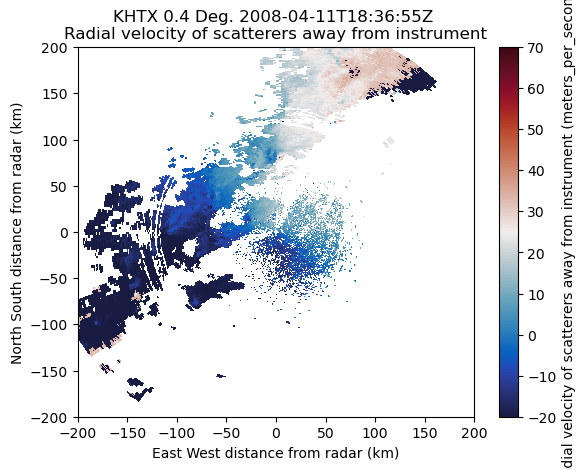

In [14]:
display = pyart.graph.RadarDisplay(nexrad_radar)
display.plot('velocity',
                     vmin=-20,
                     vmax=70,
                     cmap='pyart_balance',
                     sweep=1)
plt.ylim(-200, 200)
plt.xlim(-200, 200)

The NEXRAD level 2 data do not suffer from aliasing inside the PyDDA analysis domain of 100 km from the radar. So we will use the NEXRAD unprocessed velocity data to retrieve the winds.

In [33]:
# Use the ARMOR radar lat/lon as the center for the grid
grid_lat = radar.latitude['data'][0]
grid_lon = radar.longitude['data'][0]

# Make sure the velocity is called corrected velocity to match the corrected data from ARMOR
nexrad_radar.add_field_like('velocity',
                            'corrected_velocity',
                            nexrad_radar.fields['velocity']['data'],
                            replace_existing=True)

nexrad_grid = pyart.map.grid_from_radars([nexrad_radar],
                                         grid_limits=grid_limits,
                                         grid_shape=grid_shape,
                                         grid_origin=(grid_lat, grid_lon),
                                        )

# Convert to xarray and remove the time dimension
nexrad_ds = nexrad_grid.to_xarray().squeeze()

## Visualize the grids

Let's see what our output data looks like!

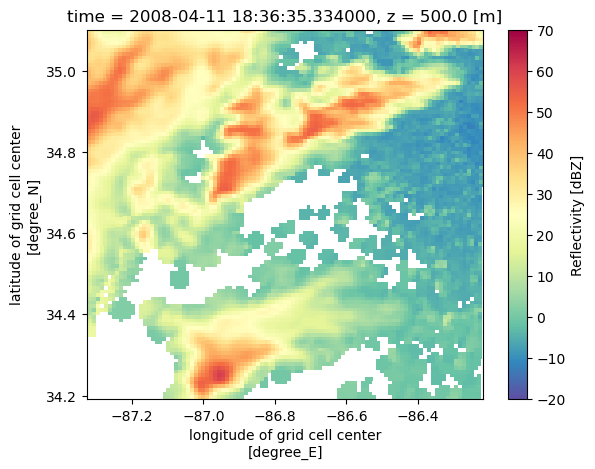

In [34]:
nexrad_ds.reflectivity.isel(z=1).plot(x='lon',
                                      y='lat',
                                      cmap='Spectral_r',
                                      vmin=-20,
                                      vmax=70)

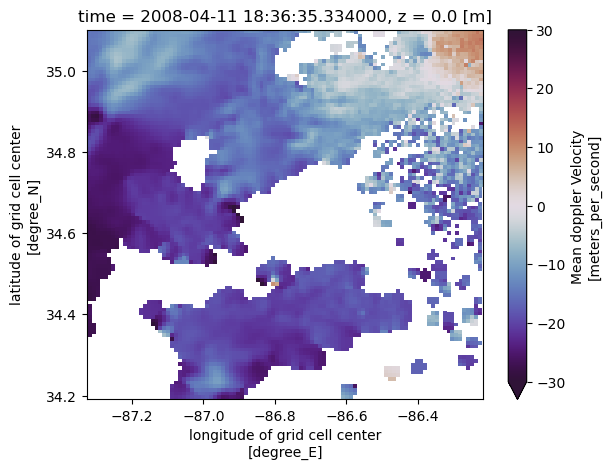

In [35]:
nexrad_ds.velocity.isel(z=0).plot(x='lon',
                                  y='lat',
                                  cmap='twilight_shifted',
                                  vmin=-30,
                                  vmax=30)

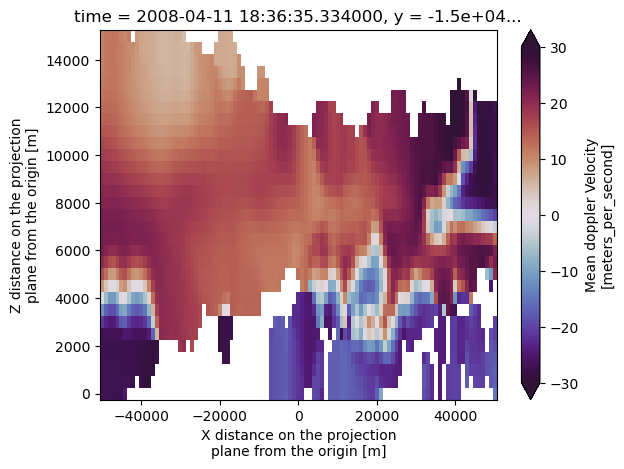

In [37]:
nexrad_ds.velocity.isel(y=35).plot(x='x',
                                  y='z',
                                  cmap='twilight_shifted',
                                  vmin=-30,
                                  vmax=30)

## PyDDA initialization

The 3DVAR wind retrieval first requires an initial guess at the wind field in order to start the cost function minimization process. PyDDA has support for using WRF and sounding data as an initial guess of the wind field as well as constant wind fields. 

| Initalization functions in **pydda.initialization** module: | Functionality         |
|-------------------------------------------------------------|-----------------------|
| make_constant_wind_field(Grid[, wind, vel_field]) | This function makes a constant wind field given a wind vector |
| make_wind_field_from_profile(Grid, profile) | This function makes a 3D wind field from a sounding. |
| make_background_from_wrf(Grid, file_path, ...) | This function makes an initalization field based off of the u and w from a WRF run.
| make_initialization_from_era_interim(Grid[, ...]) | This function will read ERA Interim in NetCDF format and add it to the Py-ART grid specified by Grid. |

For this example, we will use the closest NWS Sounding present in time as an initialization. The initial state is extremely important for the retrieval. If you specify a zero initial state, this has a tendency to have PyDDA resolve false updrafts and downdrafts in the cone of silence as the optimization loop will hold the background state to be zero where there is no radar data. Specifying the initial state, or a background constraint, will specify what the winds should be outside of the region of data coverage.

The bottom code snippet will load a University of Wyoming sounding file, remove the NaNs, then convert the 

In [168]:
col_names = ["PRES", "HGHT", "TEMP", "DWPT", "RELH", "MIXR", "DRCT", "SKNT", "THTA", "THTE", "THTV"]
sounding = pd.read_csv(
    '../../data/sounding_data/bmx_sounding_20080411_12Z.txt',
    skiprows=4, names=col_names, delimiter='\s+')
spd = sounding["SKNT"]*0.5144

u_back = -spd * np.sin(np.deg2rad(sounding["DRCT"]))
v_back = -spd * np.cos(np.deg2rad(sounding["DRCT"]))
z_back = sounding["HGHT"]
# Remove NaNs from profile
isnan = np.logical_or.reduce((~np.isfinite(u_back), ~np.isfinite(v_back), ~np.isfinite(z_back)))
u_back = u_back[~isnan]
v_back = v_back[~isnan]
z_back = z_back[~isnan]
spd = spd[~isnan]
drct = sounding["DRCT"][~isnan]
profile = pyart.core.HorizontalWindProfile(sounding["HGHT"][~isnan], spd, drct)

In [169]:
u_init, v_init, w_init = pydda.initialization.make_wind_field_from_profile(
    uah_grid, profile)

## PyDDA wind retrieval

The core wind retrieval function in PyDDA is done using **retrieval.get_dd_wind_field**. It has many potential keyword inputs that the user can enter. In this example, we are specifying:

| Input to **pydda.initialization** module: | Meaning | Value              |
|-------------------------------------------|---------|--------------------|
| Grids | The input grids to analyze. | [uah_grid, nexrad_grid] |
| u_init| Initial guess of *u* field. | u_init |
| v_init| Initial guess of *u* field. | v_init |
| w_init| Initial guess of *u* field. | w_init |
| Co | Weight for cost function related to radar observations | 1.0 |
| Cm | Weight of cost function related to mass continuity equation | 256.0|
| Cx | Weight of cost function for smoothess in the *x*-direction| 1e-3|
| Cy | Weight of cost function for smoothess in the *y*-direction| 1e-3|
| Cz | Weight of cost function for smoothess in the *z*-direction| 1e-3|
| Cb | Weight of cost function for sounding (background) constraint| 0 |
| frz| The freezing level in meters. This is to tell PyDDA where to use ice particle fall speeds in the wind retrieval verus liquid. | 5000. |
| filter_window | The window to apply the low pass filter on | 5 |
| mask_outside_opt | Mask all winds outside the Dual Doppler lobes | True
| vel_name| The name of the velocity field in the radar data | 'corrected_velocity' |
| wind_tol | Stop optimization when the change in wind speeds between iterations is less than this value |
| engine | PyDDA supports three backends for optimization: SciPy, JAX, and TensorFlow. We highly recommend the TensorFlow backend to take advantage of parallelism and GPUs for retrieval. | "tensorflow"

In [186]:
grids = pydda.retrieval.get_dd_wind_field([uah_grid, nexrad_grid], u_init,
                                          v_init, w_init, Co=1.0, Cm=256.0,
                                          Cx=0, Cy=0, Cz=0, Cb=0.,
                                          frz=5000.0, filter_window=5,
                                          mask_outside_opt=True, upper_bc=1,
                                          vel_name='corrected_velocity',
                                          wind_tol=0.05, engine="scipy")

Calculating weights for radars 0 and 1
Calculating weights for models...
Starting solver 
rmsVR = 18.32215290292774
Total points: 100207
The max of w_init is 0.0
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
      0|24251.0500|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000
The gradient of the cost functions is 0.163061494251423
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     10|   1.0689|  17.7965|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  39.1582
The gradient of the cost functions is 0.14033113216153348
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     20|   0.9181|  17.5592|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  56.4353
The gradient of the cost functions is 0.14037945939126123
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     30|   0.9184|  17.5586|   0.0000|   0.0000|   0.

## Visualize the results

Let's visualize the results. There are two ways in which this data can be visualized. One way is by using PyDDA's visualization routines. You can also use xarray to visualize the output grids.

In [187]:
ds = grids[1].to_xarray()

In [188]:
ds

<xarray.Dataset>
Dimensions:             (time: 1, z: 31, y: 101, x: 101)
Coordinates:
  * time                (time) object 2008-04-11 18:36:35.334000
  * z                   (z) float64 0.0 500.0 1e+03 ... 1.4e+04 1.45e+04 1.5e+04
    lat                 (y, x) float64 34.2 34.2 34.2 34.2 ... 35.09 35.09 35.09
    lon                 (y, x) float64 -87.32 -87.3 -87.29 ... -86.23 -86.22
  * y                   (y) float64 -5e+04 -4.9e+04 -4.8e+04 ... 4.9e+04 5e+04
  * x                   (x) float64 -5e+04 -4.9e+04 -4.8e+04 ... 4.9e+04 5e+04
Data variables:
    velocity            (time, z, y, x) float32 nan nan nan nan ... nan nan nan
    corrected_velocity  (time, z, y, x) float32 nan nan nan nan ... nan nan nan
    spectrum_width      (time, z, y, x) float32 nan nan nan nan ... nan nan nan
    reflectivity        (time, z, y, x) float32 nan nan nan nan ... nan nan nan
    ROI                 (time, z, y, x) float32 3.647e+03 ... 1.331e+03
    AZ                  (time, z, y, x) float64 234.4 234.2 ... 323.4 325.4
    EL                  (time, z, y, x) float64 -0.537 -0.5347 ... 33.0 33.69
    u                   (time, z, y, x) float64 nan nan nan nan ... nan nan nan
    v                   (time, z, y, x) float64 nan nan nan nan ... nan nan nan
    w                   (time, z, y, x) float64 nan nan nan nan ... nan nan nan

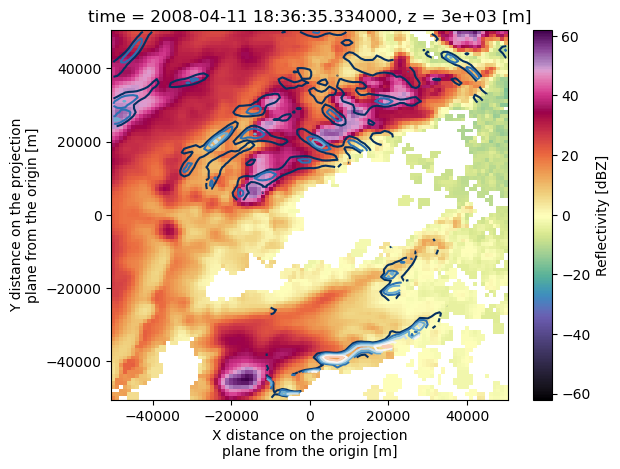

In [190]:
ds.reflectivity.sel(z=3000, method='nearest').plot(cmap='pyart_ChaseSpectral')
ds.isel(time=0).sel(z=3000, method='nearest').w.plot.contour(x='x', y='y', levels=np.arange(1, 10, 1))

## PyDDA visualization routines
PyDDA's visualization routines support the native PyART grids that are output by PyDDA. These routines have an advantage over xarray's plotting routines for adjusting your barb and quiver size by specifying their using parameters that are in scales of kilometers. This makes it easier to plot barb and quiver plots compared to using xarray's functionality. 

For example, the documentation for *pydda.vis.plot_horiz_xsection_quiver* is given below.

In [148]:
pydda.vis.plot_horiz_xsection_quiver?

Signature:
pydda.vis.plot_horiz_xsection_quiver(
    Grids,
    ax=None,
    background_field='reflectivity',
    level=1,
    cmap='pyart_LangRainbow12',
    vmin=None,
    vmax=None,
    u_vel_contours=None,
    v_vel_contours=None,
    w_vel_contours=None,
    wind_vel_contours=None,
    u_field='u',
    v_field='v',
    w_field='w',
    show_lobes=True,
    title_flag=True,
    axes_labels_flag=True,
    colorbar_flag=True,
    colorbar_contour_flag=False,
    bg_grid_no=0,
    scale=3,
    quiver_spacing_x_km=10.0,
    quiver_spacing_y_km=10.0,
    contour_alpha=0.7,
    quiverkey_len=5.0,
    quiverkey_loc='best',
    quiver_width=0.01,
)
Docstring:
This procedure plots a horizontal cross section of winds from wind fields
generated by PyDDA using quivers. The length of the quivers varies 
with horizontal wind speed.

Parameters
----------
Grids: list
    List of Py-ART Grids to visualize
ax: matplotlib axis handle
    The axis handle to place the plot on. Set to None to plot on t

PyDDA has the following visualization routines for your sets of grids:

| Procedure | Description |
|-----------|-------------|
| plot_horiz_xsection_barbs(Grids[, ax, ...]) | Horizontal cross section of winds from wind fields generated by PyDDA using barbs.
| plot_xz_xsection_barbs(Grids[, ax, ...]) | Cross section of winds from wind fields generated by PyDDA in the X-Z plane using barbs.
| plot_yz_xsection_barbs(Grids[, ax, ...]) | Cross section of winds from wind fields generated by PyDDA in the Y-Z plane using barbs.
| plot_horiz_xsection_barbs_map(Grids[, ax, ...]) | Horizontal cross section of winds from wind fields generated by PyDDA onto a geographical map using barbs.
| plot_horiz_xsection_streamlines(Grids[, ax, ...]) | Horizontal cross section of winds from wind fields generated by PyDDA using streamlines.
| plot_xz_xsection_streamlines(Grids[, ax, ...])| Cross section of winds from wind fields generated by PyDDA in the X-Z plane using streamlines.
| plot_yz_xsection_streamlines(Grids[, ax, ...]) | Cross section of winds from wind fields generated by PyDDA in the Y-Z plane using streamlines.
| plot_horiz_xsection_streamlines_map(Grids[, ...]) | Horizontal cross section of winds from wind fields generated by PyDDA using streamlines.
| plot_horiz_xsection_quiver(Grids[, ax, ...]) | Horizontal cross section of winds from wind fields generated by PyDDA using quivers.  
| plot_xz_xsection_quiver(Grids[, ax, ...]) | Cross section of winds from wind fields generated by PyDDA in the X-Z plane using quivers.
| plot_yz_xsection_quiver(Grids[, ax, ...]) | Cross section of winds from wind fields generated by PyDDA in the Y-Z plane using quivers.
| plot_horiz_xsection_quiver_map(Grids[, ax, ...]) | Horizontal cross section of winds from wind fields generated by PyDDA using quivers onto a geographical map.

Let's show a quiver plot of this storm!

We have specified the quivers to be 4 km apart and moved the key to the bottom right with the specific length indicating 20 m/s winds. Let's look at the 3 km level.

<AxesSubplot: title={'center': 'PyDDA retreived winds @3.18 km'}, xlabel='X [km]', ylabel='Y [km]'>

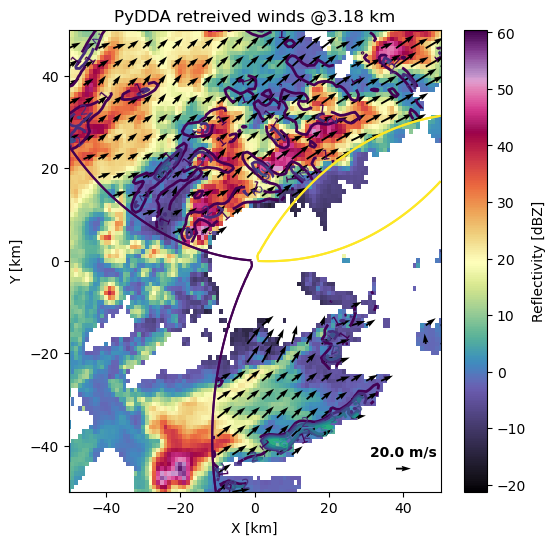

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
pydda.vis.plot_horiz_xsection_quiver(
    grids, quiver_spacing_x_km=4.0, quiver_spacing_y_km=4.0, quiver_width=0.005,
    quiverkey_len=20.0, w_vel_contours=np.arange(1, 10, 1), level=6, cmap='pyart_ChaseSpectral', ax=ax,
    quiverkey_loc='bottom_right')

We can zoom in and modify the plot using standard matplotlib functions on the axis handle.

It is much easier to see updrafts being placed just to the outside of the strongest precipitation, with potential new growth in the north of the domain with updraft velocities > 7 m/s. The precipitation is downwind of the updraft as we would expect.

Updrafts are right tilted due to the horizontal wind shear. The horizontal wind shear also causes the most intense precipitation to be downshear of the updraft. This therefore shows us that we have a good quality wind retrieval below about 5 km in altitude.

(0.0, 8.0)

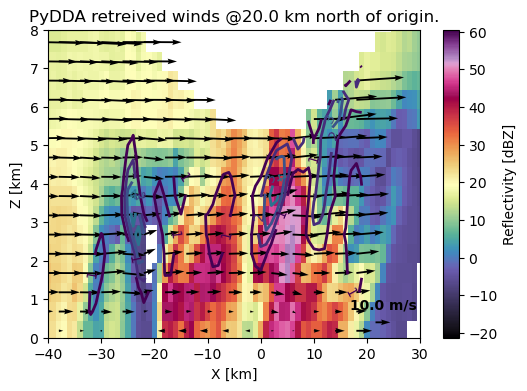

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
pydda.vis.plot_xz_xsection_quiver(
    grids, quiver_spacing_x_km=4.0, quiver_spacing_z_km=1.0, quiver_width=0.005,
    quiverkey_len=10.0, w_vel_contours=np.arange(1, 10, 1), level=70, cmap='pyart_ChaseSpectral', ax=ax,
    quiverkey_loc='bottom_right')
ax.set_xlim([-40, 30])
ax.set_ylim([0, 8])

Let's view a horizontal cross section with barbs!

(0.0, 50.0)

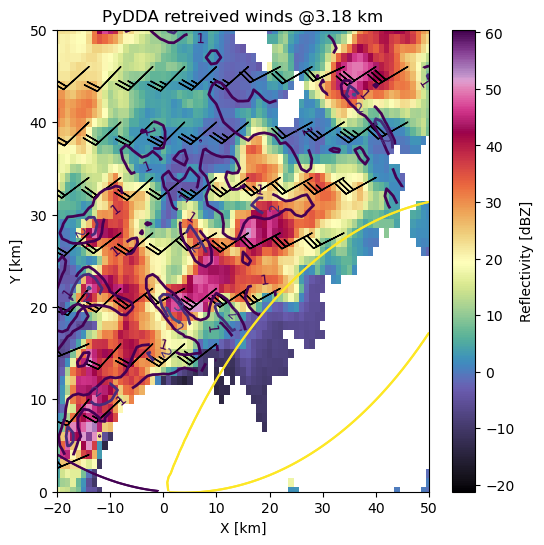

In [201]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
pydda.vis.plot_horiz_xsection_barbs(
    grids, barb_spacing_x_km=6.0, barb_spacing_y_km=6.0,
    w_vel_contours=np.arange(1, 10, 1), level=6, cmap='pyart_ChaseSpectral', ax=ax)
ax.set_xlim([-20, 50])
ax.set_ylim([0, 50])